# Testing Code

Test a multi-class classification model to identify storage I/O behaviors of a server workload as one of the following determined I/O patterns:

*   File Servers
*   OLTP
*   Streaming Reads
*   Streaming Writes
*   Web Servers
*   Workstations

The model would reject unknown-I/O-pattern workload by leveraging activation scores.

## Mount Storage

Mount Google Drive for loading model and dataset afterward.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Must have:
- Classification model
- Activation scores
- Testing dataset (and `selected_counters.txt` if you want to read from raw data (csv))

In [2]:
%cd /content/drive/MyDrive/HPE_APO/ML\ Model/Testing
!ls

/content/drive/MyDrive/HPE_APO/ML Model/Testing
activation_fio_only.pickle	   model_fio_only.ckpt	   selected_counters.txt  Testing.ipynb
activation_fio_vdbench_mix.pickle  model_vdbench_mix.ckpt  testing_dataset


## Prepare

### Constants

In [3]:
N_SAMPLES = 61      # 5-min sampling duration & 5-sec sampling rate
N_COUNTERS = 103    # Performace counters
N_CLASSES = 6       # I/O patterns
IOPATTERN_TO_LABEL = {
    "File_Server": 0,
    "OLTP": 1,
    "Streaming_Reads": 2,
    "Streaming_Writes": 3,
    "Web_Server": 4,
    "Workstations": 5,
}

### Testing Data

Known I/O patterns:
- File Servers
- OLTP
- Streaming Reads
- Streaming Writes
- Web Servers
- Workstations

Unknown-I/O-patterns workloads can be categorized into 5 types:
- Type 1: Distribution of request sizes is similar to File Server
- Type 2: Distribution of request sizes is similar to OLTP
- Type 3: Distribution of request sizes is similar to Streaming Reads and Streaming Writes
- Type 4: Distribution of request sizes is similar to Web Server
- Type 5: Distribution of request sizes is similar to Workstation

#### Read Raw Data

1. Read `csv` files, which are the profiling results from `logman`.
    * One data instance contains 61 samples of 103 performance counters.
        * 5-min sampling duration & 5-sec sampling rate
2. Extract features, the performance counters we care about, within the effective duration (the effective duration in our experiment is the last 5 minutes of the profiling).

In [4]:
import numpy as np
import pandas as pd
import re

# Get extracted counters
def get_counter(counter_path):
    if not counter_path.exists:
        raise Exception("counter is not found")

    with counter_path.open("r") as f:
        lines = f.readlines()

    return [line.strip() for line in lines]

# Rename counters, e.g., process(fio) -> process(app)
def rename_counter(df):
    rename_list = {}
    for col_name in df.columns:
        new_col_name = re.sub("^Process\([\w#]+\)", "Process(app)", col_name)
        rename_list.update({col_name: new_col_name})

    return df.rename(columns=rename_list)

# Extract samples within the effective duration
def filter_rows(df):
    df = df[-1-N_SAMPLES:-1]
    return df

def check_format(instance, file):
    # Check null value
    if np.any(np.isnan(instance)):
        raise Exception("instance contains null data")

    # Check the shape of instance is (N_SAMPLES, N_COUNTERS)
    if instance.shape != (N_SAMPLES, N_COUNTERS):
        raise Exception("Shape of file {} is {}.".format(file, instance.shape))

def get_instances_and_labels(data_subdir, counters):
    if not data_subdir.exists:
        raise Exception("directory not found")

    instances, labels, parameters = [], [], []

    for file in data_subdir.iterdir():
        # Get instance
        df = pd.read_csv(file)
        df = rename_counter(df)
        df = df[counters]
        df = filter_rows(df)
        df = df.replace(regex="\s", value=0.0)
        instance = df.astype("float").to_numpy()
        check_format(instance, file)
        instances.append(instance)

        # Get label and parameters
        f_str = str(file.name)
        unknown_groups = re.match("^Unknown(\d+)_(\d+)_(\d+)", f_str)
        if unknown_groups:  # unknown-I/O-pattern workloads
            # label
            labels.append(None)
            # parameter for generating workloads
            unknown_type = unknown_groups.group(1)  # request size
            readpct = unknown_groups.group(2)       # read percentage
            randpct = unknown_groups.group(3)       # random percentage
            parameters.append(np.array([unknown_type, readpct, randpct]))
        else:       # known-I/O-pattern workloads
            # label
            known_groups = re.match("^([File_Server|OLTP|Streaming_Reads|Streaming_Writes|Web_Server|Workstations]+)_", f_str)
            iopattern = known_groups.group(1)
            labels.append(IOPATTERN_TO_LABEL[iopattern])
            # parameter
            parameters.append(None)

    return instances, labels, parameters

def preprocess(data_dir, counter_path):
    instances, labels, parameters = [], [], []

    counters = get_counter(counter_path)

    data_subdirs = [file for file in data_dir.iterdir() if file.is_dir()]
    for data_subdir in data_subdirs:
        new_instances, new_labels, new_parameters = get_instances_and_labels(data_subdir, counters)
        instances.extend(new_instances)
        labels.extend(new_labels)
        parameters.extend(new_parameters)

    # Convert array to numpy array
    data = {
        "instances": np.stack(instances, axis=0),
        "labels": np.stack(labels, axis=0),
        "parameters" : np.stack(parameters, axis=0),
    }

    return data

To test different dataset, change `DATA_TO_TEST`:
* fio_known
* fio_unknown
* vdbench_known
* vdbench_unknown

Save data in Python's data structure to avoid time-consuming I/Os from reading `csv` files.
* `cache`: directory for temporary data.

In [5]:
import os
from pathlib import Path
import pickle

DATA_TO_TEST = "fio_known"
data_dir = Path("testing_dataset") / DATA_TO_TEST
counter_path = Path("selected_counters.txt")
cache_dir = Path("cache")

# If preprocessed data exists in cache folder, load it directly.
IS_CACHED = True

# Create a cache directory
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
    IS_CACHED = False

data_cpath = cache_dir / (DATA_TO_TEST + ".pickle")
IS_CACHED = IS_CACHED and os.path.exists(data_cpath)
if IS_CACHED:
   with data_cpath.open("rb") as f:
        data = pickle.load(f)
else:
    data = preprocess(data_dir, counter_path)
    with data_cpath.open("wb") as f:
        pickle.dump(data, f)

#### Build Dataloader

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 8

instances, labels, parameters_list = data["instances"], data["labels"], data["parameters"]
print("Shape of instance : {}".format(instances.shape))

class TestDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.data.shape[0]

test_set = TestDataset(instances)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Shape of instance : (575, 61, 103)


NameError: ignored

### Activation Scores

Load activation scores for extreme value theory (EVT) to implement rejection mechanisms.
- Threshold-based rejection
- OpenMax-based rejection

In [7]:
import pickle

with open("activation_fio_only.pickle", "rb") as f:
    activation_scores_all = pickle.load(f)
#with open("activation_fio_vdbench_mix.pickle", "rb") as f:
#    activation_scores_all = pickle.load(f)

In [8]:
import numpy as np

def as_all2max(activation_scores_all):
    as_all = np.asarray(activation_scores_all)
    as_max_idcs = as_all.argmax(axis=0)
    as_max = [[],[],[],[],[],[]]

    for i, as_max_idx in enumerate(as_max_idcs):
        as_max[as_max_idx].append(as_all[as_max_idx][i])

    return as_max

activation_scores_max = as_all2max(activation_scores_all)

### Model

Load the classification model and set it to evaluation (testing) mode.

In [9]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(N_SAMPLES * N_COUNTERS, 2048)

        self.layer2 = nn.Linear(2048, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, N_CLASSES)

        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x,start_dim=1)

        x = self.layer1(x)
        x = self.act_fn(x)

        x = self.layer2(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        x = self.act_fn(x)

        x = self.out(x)

        return x

device = "cuda"
model = Classifier().to(device)
#model.load_state_dict(torch.load("model_fio_only.ckpt"))
model.load_state_dict(torch.load("model_vdbench_mix.ckpt"))

<All keys matched successfully>

## A. Classification (Baseline)

The vanilla classification model without rejection capability.

In [17]:
preds = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data.to(device)
        outputs = model(inputs)
        _, test_preds = torch.max(outputs, 1) # Get the index of the class with the highest probability
        preds += test_preds.cpu().tolist()

In [18]:
preds = np.array(preds)
corrects = len(labels[labels == preds])
print("Numbers of correct: {}; Numbers of misclassified: {}; Test Acc: {:3.6f}".format(
    corrects, len(labels) - corrects, corrects / len(labels)
))

Numbers of correct: 568; Numbers of misclassified: 7; Test Acc: 0.987826


## B. Classification with Threshold-Based Rejection

Any prediction lower than the threshold of the predicted class will be rejected.

The prediction at inference time depends on the highest activation score.
* Because directly applying ArgMax to the logits provides the same result as applying ArgMax to the logits after computing the SoftMax.

### Get Thresholds

1. Single threshold

    A naive approach for detecting unknown classes to set a threshold on the highest activation score.

2. Multi threshold

    N classes set with N thresholds.

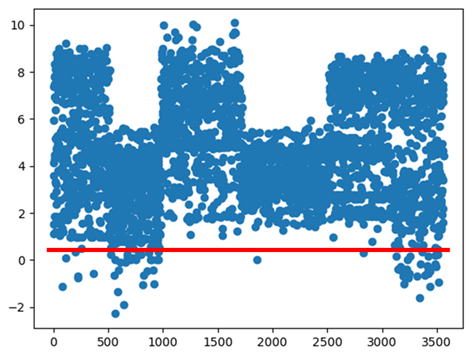
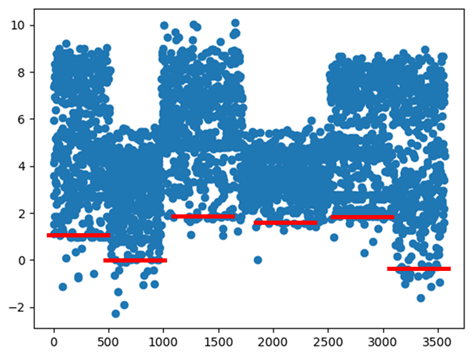

In [19]:
def find_threshold(data, ratio):
    sorted_data = sorted(data)
    threshold_index = int(len(sorted_data) * (1-ratio))
    threshold = sorted_data[threshold_index]
    return threshold

def find_multi_threshold(max_values, ratio):
    thresholds = dict([(i, None) for i in range(N_CLASSES)])
    for i in range(N_CLASSES):
        thresholds[i] = find_threshold(max_values[i], ratio)
    return thresholds

def find_single_threshold(total, ratio):
    single_threshold = find_threshold(total, ratio)
    return single_threshold

* ***MaxAS***: The highest activation score.
* `TH`: 99% of `TH` indicates that the 99% of ***MaxAS***es of correctly classified samples of each class at training time are higher than their corresponding threshold.

In [20]:
MULTI_THRESHOLD = True
TH = 0.99
if MULTI_THRESHOLD:
    thresholds = find_multi_threshold(activation_scores_max, TH)
    print("TH: {}, threshold values: {}".format(TH, thresholds))
else:
    total = []
    for activation_scores in activation_scores_max:
        total += activation_scores
    single_threshold = find_single_threshold(total, TH)
    print("TH: {}, threshold value: {}".format(TH, single_threshold))

TH: 0.99, threshold values: {0: -747730.75, 1: -413901.59375, 2: 82562880.0, 3: 70787616.0, 4: -714024.6875, 5: -220099.546875}


### Testing

An input sample of known-I/O-pattern workload may be:
* Correctly classified
* Misclassified
* Mis-rejected

An input sample of unknown-I/O-pattern workload may be:
* Correctly rejected
* Misclassified

**NOTE**: That prediction of 7th class (N_CLASS + 1) means rejection.

In [40]:
# known = correct_classify + mis_classify + mis_reject
# unknown = correct_reject + mis_classify
known, unknown = [0, 0, 0],  [0, 0]
preds, max_values, mispred_logs= [], [], []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data.to(device)
        outputs = model(inputs)
        # Get the index of the class with the highest probability
        max_value_batch, test_pred = torch.max(outputs, 1)

        max_value_batch, pred_batch = max_value_batch.cpu().tolist(), test_pred.cpu().tolist()
        max_values += max_value_batch
        preds += pred_batch

    for max_value, pred, label, parameters in zip(max_values, preds, labels, parameters_list):
        reject_flag = False
        if MULTI_THRESHOLD:
            if max_value < thresholds[pred]:
                reject_flag = True
        else:
            if max_value < single_threshold:
                reject_flag = True

        if label is not None:   # known-I/O-pattern workload
            if reject_flag:
                known[2] += 1   # mis_reject
                mispred_logs.append([label, None, None, N_CLASSES+1])
            elif pred == label:
                known[0] += 1   # correct_classify
            else:
                known[1] += 1   # mis_classify
                mispred_logs.append([label, None, None, pred])

        else:                   # unknown-I/O-pattern workload
            if reject_flag:
                unknown[0] += 1 # correct_reject
            else:
                unknown[1] += 1 # mis_classify
                mispred_logs.append(parameters.tolist() + [str(pred)])

if sum(known) != 0:
    print("correct_classify: {}; mis_classify: {}; misreject: {}; classification acc: {:.2f}% (TH: {})".format(
        known[0], known[1], known[2], known[0]/sum(known)*100, TH
    ))
if sum(unknown) != 0:
    print("correct_reject: {}; mis_classify: {}; rejection rate: {:.2f}% (TH: {})".format(
        unknown[0], unknown[1], unknown[0]/sum(unknown)*100, TH
    ))

correct_classify: 568; mis_classify: 7; misreject: 0; classification acc: 98.78% (TH: 0.99)


## C. Classification with OpenMax-Based Rejection

### Prepare OpenMax

#### Construct Weibull distribution

Construct a Weibull distribution model for each class with:
* The average of the activation scores of the correctly classified training samples
* The distances between the training samples and their average  activation score

In [1]:
import numpy as np
import sys

%pip install libmr

try:
    import libmr
except ImportError:
    print("LibMR not installed")
    sys.exit()

def weibull_tailfitting(activation_scores_all, tailsize):
    """ Read activation scores and fit weibull model for each I/O pattern

    Input:
    --------------------------------
    activation_scores : activation scores of only the correctly classified
                        training examples for each I/O pattern
    - shape:
    - [
    -     [activation_score_1, activation_score_2, ..., activation_score_n],
    -     [activation_score_1, activation_score_2, ..., activation_score_n],
    -     ...
    -     [activation_score_1, activation_score_2, ..., activation_score_n],
    - ]

    Output:
    --------------------------------
    weibull_models : Perform EVT based analysis using tails of distances and
                     save weibull model parameters for re-adjusting scores
    """

    weibull_models = []
    # for each I/O pattern, read activation scores, and perform weibull fitting
    for iopattern, activation_scores in enumerate(activation_scores_all):
        mean_activation_score = np.mean(activation_scores)
        distance_scores = np.zeros(len(activation_scores))
        for i, activation_score in enumerate(activation_scores):
            distance_scores[i] = np.abs(activation_score - mean_activation_score)

        mr = libmr.MR()
        tailtofit = np.sort(distance_scores)[-tailsize:]
        mr.fit_high(tailtofit, tailsize)

        weibull_models += [{
            "mean_activation_score": mean_activation_score,
            "weibull_model": mr,
        }]

    return weibull_models

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      Traceback (most recent call last):
        File "C:\Users\ASUS\AppData\Local\Temp\pip-install-6cnuylpr\libmr_14d9569f2f6b44a6b609000f06f676b2\setup.py", line 6, in <module>
          from Cython.Build import cythonize
      ModuleNotFoundError: No module named 'Cython'
      
      During handling of the above exception, another exception occurred:
      
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\ASUS\AppData\Local\Temp\pip-install-6cnuylpr\libmr_14d9569f2f6b44a6b609000f06f676b2\setup.py", line 8, in <module>
          raise ImportError("You must have Cython >=0.17 to build LibMR's python bindings!")
      ImportError: You must have Cython >=0.17 to build LibMR's python bindings!
      [end of output]
  
  note: This

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.
LibMR not installed


AttributeError: 'tuple' object has no attribute 'tb_frame'

#### Create OpenMax Layer

The activation scores for all known classes are redistributed by fitting the Weibull models, and one collective pseudo activation score for unknown classes is calculated.
* Recalibration is to scale the Weibull CDF probability in OpenMax's algorithm, which is not necessary in OpenMax-based rejection.

The prediction is obtained by applying the ArgMax function to the redistributed activation scores of known and unknown classes.

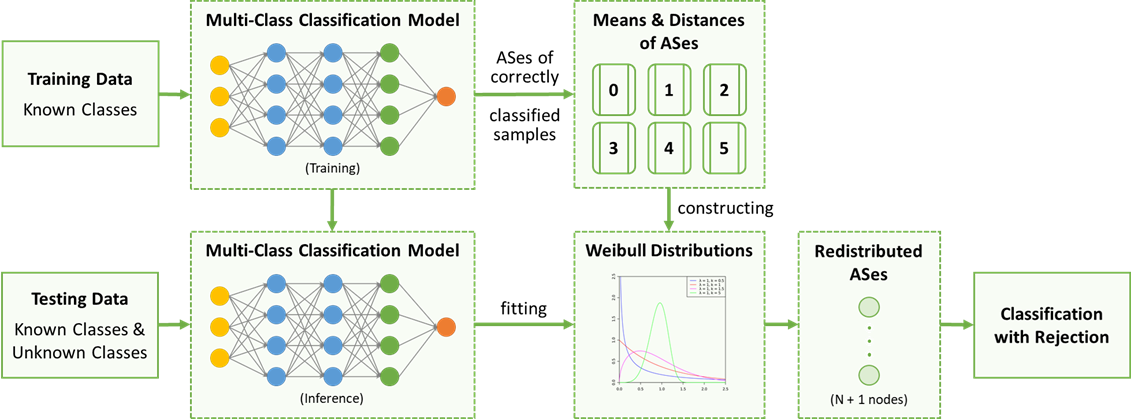

In [11]:
def recalibrate_scores(weibull_models, alpharank):
    mean_activation_vector = np.zeros(N_CLASSES)
    for i, weibull_model in enumerate(weibull_models):
        mean_activation_vector[i] = weibull_model["mean_activation_score"]
    ranked_list = mean_activation_vector.argsort()
    alpha_weights = [((alpharank+1) - i)/float(alpharank) for i in range(1, alpharank+1)]
    ranked_alpha = np.zeros(N_CLASSES)
    for i in range(len(alpha_weights)):
        ranked_alpha[ranked_list[i]] = alpha_weights[i]

    return ranked_alpha

def compute_openmax(activation_vectors, weibull_models, alpharank=None):
    """
    Given activation vector and list of weibull models for each I/O pattern,
    compute openmax scores

    Input:
    ---------------
    activation_vectors : the original activation scores for each I/O pattern
    weibull_models : pre-computed weibull_models obtained from weibull_tailfitting() function

    Output:
    ---------------
    openmax_scores : scores for each I/O pattern and unknown computed using OpenMax

    """

    if alpharank is not None:
        ranked_alpha = recalibrate_scores(weibull_models, alpharank)

    openmax_vectors = []
    for activation_vector in activation_vectors:
        openmax_knowns = []
        openmax_unknown = 0
        # Recalibrate each score for each I/O pattern to include score of unknown
        for iopattern in range(N_CLASSES):
            weibull_model = weibull_models[iopattern]
            mean_activation_score = weibull_model["mean_activation_score"]
            weibull_model = weibull_model["weibull_model"]

            # get distance between current score and mean score
            activation_score = activation_vector[iopattern]
            distance = abs(mean_activation_score - activation_score)

            # obtain w_score for the distance and compute probability of the
            # distance being unknown wrt to mean training vector and channel
            # distances for I/O pattern under consideration
            wscore = weibull_model.w_score(distance)

            if alpharank is not None:
                wscore = wscore * ranked_alpha[iopattern]
            modified_score = activation_score * (1 - wscore)
            openmax_knowns += [modified_score]
            openmax_unknown += activation_score - modified_score

        openmax_unknown = openmax_unknown

        openmax_vectors += [openmax_knowns + [openmax_unknown]]

    return openmax_vectors

def openmax_layer(activation_vectors, weibull_models, alpharank=None):
    x = activation_vectors.cpu()
    x = compute_openmax(x, weibull_models, alpharank)
    x = torch.FloatTensor(x)

    return x

### Testing

#### Original

* `Known = [Correctly classified, Misclassified, Mis-rejected]`
* `Unknown = [Correctly rejected, Misclassified]`

In [72]:
# Use loop to find the good parameters

# ------------- Original ------------- #
ALPHA_RANK_LIST = [1,2,3,4,5,6]
TAIL_SIZE_LIST = list(range(4,20))

results = []
max_acc, max_rej = -1.0, -1.0
best_classify_result, best_reject_result = None, None
for tail_size in TAIL_SIZE_LIST:
    weibull_models = weibull_tailfitting(activation_scores_all, tail_size)

    for alpha_rank in ALPHA_RANK_LIST:
        # known = correct_classify + mis_classify + mis_reject
        # unknown = correct_reject + mis_classify
        known, unknown = [0, 0, 0],  [0, 0]
        preds, mispred_logs= [], []
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs = data.to(device)
                outputs = model(inputs)
                outputs = openmax_layer(outputs, weibull_models, alpha_rank)
                _, pred_batch = torch.max(outputs, 1)
                preds += pred_batch.cpu().tolist()

        for pred, label, parameters in zip(preds, labels, parameters_list):
            reject_flag = False
            if pred >= N_CLASSES:
                reject_flag = True

            if label is not None:   # known-I/O-pattern workload
                if reject_flag:
                    known[2] += 1   # mis_reject
                    mispred_logs.append([label, None, None, pred])
                elif pred == label:
                    known[0] += 1   # correct_classify
                else:
                    known[1] += 1   # mis_classify
                    mispred_logs.append([label, None, None, pred])

            else:                   # unknown-I/O-pattern workload
                if reject_flag:
                    unknown[0] += 1 # correct_reject
                else:
                    unknown[1] += 1 # mis_classify
                    mispred_logs.append(parameters.tolist() + [str(pred)])

        results += [[alpha_rank, tail_size] + known + unknown]
        result = "known: {}; unknown: {}; (alpha_rank: {}, tail_size: {})".format(
            known, unknown, alpha_rank, tail_size)
        print(result)

        if sum(known) != 0:
            acc = known[0] / sum(known) * 100
            if acc > max_acc:
                max_acc = acc
                best_classify_result = result
        if sum(unknown) != 0:
            rej = unknown[0] / sum(unknown) * 100
            if rej > max_rej:
                max_rej = rej
                best_reject_result = result

if best_classify_result is not None:
    print("Best classification result:\n" + best_classify_result)
if best_reject_result is not None:
    print("Best rejection result:\n" + best_reject_result)

known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 1, tail_size: 4)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 2, tail_size: 4)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 3, tail_size: 4)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 4, tail_size: 4)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 5, tail_size: 4)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 6, tail_size: 4)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 1, tail_size: 5)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 2, tail_size: 5)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 3, tail_size: 5)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 4, tail_size: 5)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 5, tail_size: 5)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 6, tail_size: 5)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 1, tail_size: 6)
known: [0, 0, 0]; unknown: [482, 1557]; (alpha_rank: 2, tail_size: 6)
known: [0, 0, 0]; un

#### Integrated

In [98]:
# Use loop to find the good parameters

# ------------ Integrated ------------ #
ALPHA_RANK_LIST = [None]
TAIL_SIZE_LIST = list(range(4,20))

# ----- Best based on Integrated ----- #
#ALPHA_RANK_LIST = [None]
#TAIL_SIZE_LIST = [4]

results = []
max_acc, max_rej = -1.0, -1.0
best_classify_result, best_reject_result = None, None
for tail_size in TAIL_SIZE_LIST:
    weibull_models = weibull_tailfitting(activation_scores_all, tail_size)

    for alpha_rank in ALPHA_RANK_LIST:
        # known = correct_classify + mis_classify + mis_reject
        # unknown = correct_reject + mis_classify
        known, unknown = [0, 0, 0],  [0, 0]
        mlp_preds, openmax_preds, mispred_logs= [], [], []
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs = data.to(device)
                outputs = model(inputs)
                _, mlp_pred_batch = torch.max(outputs, 1)
                outputs = openmax_layer(outputs, weibull_models, alpha_rank)

                _, openmax_pred_batch = torch.max(outputs, 1)

                mlp_preds += mlp_pred_batch.cpu().tolist()
                openmax_preds += openmax_pred_batch.cpu().tolist()

        for mlp_pred, openmax_pred, label, parameters in zip(mlp_preds, openmax_preds, labels, parameters_list):
            reject_flag = False
            if openmax_pred >= N_CLASSES:
                reject_flag = True

            if label is not None:   # known-I/O-pattern workload
                if reject_flag:
                    known[2] += 1   # mis_reject
                    mispred_logs.append([label, None, None, openmax_pred])
                elif mlp_pred == label:
                    known[0] += 1   # correct_classify
                else:
                    known[1] += 1   # mis_classify
                    mispred_logs.append([label, None, None, mlp_pred])

            else:                   # unknown-I/O-pattern workload
                if reject_flag:
                    unknown[0] += 1 # correct_reject
                else:
                    unknown[1] += 1 # mis_classify
                    mispred_logs.append(parameters.tolist() + [str(mlp_pred)])

        results += [[alpha_rank, tail_size] + known + unknown]
        result = "known: {}; unknown: {}; (alpha_rank: {}, tail_size: {})".format(
            known, unknown, alpha_rank, tail_size)
        print(result)

        if sum(known) != 0:
            acc = known[0] / sum(known) * 100
            if acc > max_acc:
                max_acc = acc
                best_classify_result = result
        if sum(unknown) != 0:
            rej = unknown[0] / sum(unknown) * 100
            if rej > max_rej:
                max_rej = rej
                best_reject_result = result

if best_classify_result is not None:
    print("Best classification result:\n" + best_classify_result)
if best_reject_result is not None:
    print("Best rejection result:\n" + best_reject_result)

known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 4)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 5)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 6)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 7)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 8)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 9)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 10)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 11)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 12)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 13)
known: [0, 0, 0]; unknown: [936, 1103]; (alpha_rank: None, tail_size: 14)
known: [0, 0, 0]; unknown: [938, 1101]; (alpha_rank: None, tail_size: 15)
known: [0, 0, 0]; unknown: [938, 1101]; (alpha_rank: None, tail_size: 16)
known: [0, 0, 0]; unknown: [938, 1101]; (alp

### Save Result

- Prediction results, with each:
    - `[alpha_rank, tail_size, known[0], known[1], known[2], unknown[0], unknown[1]]`
        - `known = [correct_classify, mis_classify, mis_reject]`
        - `unknown = [correct_reject, mis_classify]`
- Misprediction logs, with each:
    - For known: `[label, none, none, prediction]`
    - For unknown: `[type, read_percentage, random_percentage, prediction]`

**NOTE**: That prediction of 7th class (N_CLASS + 1) means rejection.

Prediction results

In [99]:
#opath = cache_dir / "testing_openmax_original_known.pickle"
#opath = cache_dir / "testing_openmax_original_unknown.pickle"
opath = cache_dir / "testing_openmax_integrated_known.pickle"
#opath = cache_dir / "testing_openmax_integrated_unknown.pickle"
with opath.open("wb") as f:
    pickle.dump(results, f)

Mispredict logs

In [ ]:
import json
with open("known_mispred_logs.json", "w") as f:
    json.dump(mispred_logs, f)

In [ ]:
import json
with open("unknown_mispred_logs.json", "w") as f:
    json.dump(mispred_logs, f)

### Evaluate Classification Accuracy (or Rejection Rate)

Visualize classification accuracy for known classes or rejection rate for unknown classes under different alpha ranks and tail sizes.

#### Original



In [87]:
from pathlib import Path
import pickle

cache_dir = Path("cache")
ipath = cache_dir / "testing_openmax_original_known.pickle"
#ipath = cache_dir / "testing_openmax_original_unknown.pickle"
with ipath.open("rb") as f:
    results = pickle.load(f)

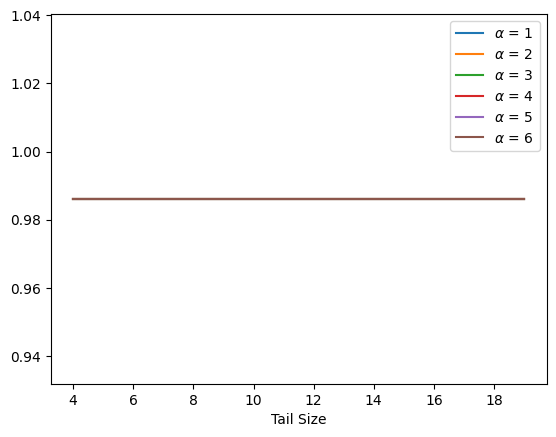

In [88]:
import numpy as np
import matplotlib.pyplot as plt

ALPHA_RANK_LIST = [1,2,3,4,5,6]
TAIL_SIZE_LIST = list(range(4,20))

tail_size_min = min(TAIL_SIZE_LIST)

result_xs = np.empty((len(ALPHA_RANK_LIST), len(TAIL_SIZE_LIST)))
result_ys = np.empty((len(ALPHA_RANK_LIST), len(TAIL_SIZE_LIST)))

for result in results:
    result_xs[result[0]-1][result[1]-tail_size_min] = result[1]
    if result[2] + result[3] + result[4] > 0:
        result_ys[result[0]-1][result[1]-tail_size_min] = result[2]/(result[2]+result[3]+result[4])
    elif result[5] + result[6] > 0:
        result_ys[result[0]-1][result[1]-tail_size_min] = result[5]/(result[5]+result[6])

for result_x, result_y in zip(result_xs, result_ys):
    plt.plot(result_x, result_y)

plt.xlabel("Tail Size")
plt.legend([r"$\alpha$ = 1", r"$\alpha$ = 2", r"$\alpha$ = 3", r"$\alpha$ = 4", r"$\alpha$ = 5", r"$\alpha$ = 6"])
plt.show()

#### Integrated

In [102]:
from pathlib import Path
import pickle

cache_dir = Path("cache")
ipath = cache_dir / "testing_openmax_integrated_known.pickle"
#ipath = cache_dir / "testing_openmax_integrated_unknown.pickle"
with ipath.open("rb") as f:
    results = pickle.load(f)

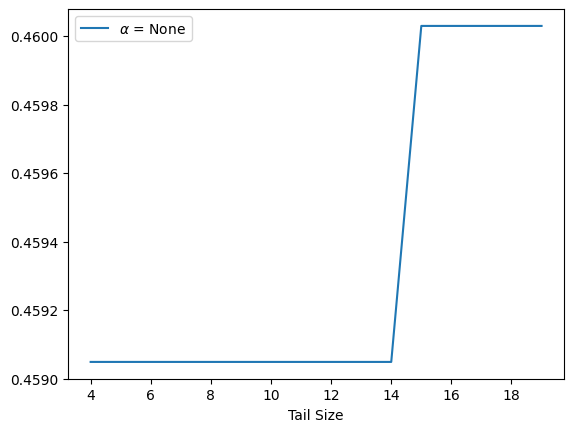

In [103]:
import numpy as np
import matplotlib.pyplot as plt

ALPHA_RANK_LIST = [None]
TAIL_SIZE_LIST = list(range(4,20))

tail_size_min = min(TAIL_SIZE_LIST)

result_xs = np.empty((len(ALPHA_RANK_LIST), len(TAIL_SIZE_LIST)))
result_ys = np.empty((len(ALPHA_RANK_LIST), len(TAIL_SIZE_LIST)))

for result in results:
    result_xs[0][result[1]-tail_size_min] = result[1]
    if result[2] + result[3] + result[4] > 0:
        result_ys[0][result[1]-tail_size_min] = result[2]/(result[2]+result[3]+result[4])
    elif result[5] + result[6] > 0:
        result_ys[0][result[1]-tail_size_min] = result[5]/(result[5]+result[6])

for result_x, result_y in zip(result_xs, result_ys):
    plt.plot(result_x, result_y)

plt.xlabel("Tail Size")
plt.legend([r"$\alpha$ = None"])
plt.show()

### Evaluate F-Score

Show the trend of F-score for different tail sizes.

In [104]:
from pathlib import Path
import pickle

cache_dir = Path("cache")

ipath = cache_dir / "testing_openmax_integrated_known.pickle"
with ipath.open("rb") as f:
    ret_knowns = pickle.load(f)

ipath = cache_dir / "testing_openmax_integrated_unknown.pickle"
with ipath.open("rb") as f:
    ret_unknowns = pickle.load(f)

([None, 4, 567, 7, 1, 0, 0], [None, 4, 0, 0, 0, 936, 1103])


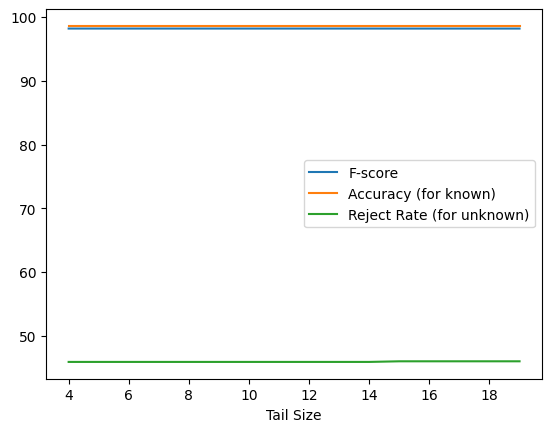

In [110]:
import matplotlib.pyplot as plt

BETA = 1.2
KU_RATIO = 0.95 # Ratio of known-I/O-pattern and unknown-I/O-pattern workloads

fx = []
fy = []
accy = []
rejy = []
maxf = -1
for ret_known, ret_unknown in zip(ret_knowns, ret_unknowns):
    # known = correct_classify + mis_classify + mis_reject
    # unknown = correct_reject + mis_classify
    acc = (ret_known[2])/(ret_known[2] + ret_known[3] + ret_known[4])
    rej = (ret_unknown[5])/(ret_unknown[5] + ret_unknown[6])

    true_positive = acc
    false_positive = rej
    false_negative = 1 - true_positive

    true_positive = true_positive * KU_RATIO
    false_positive = false_positive * (1 - KU_RATIO)
    false_negative = false_negative * KU_RATIO

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    fscore = (1 + BETA * BETA) * precision * recall / (BETA * BETA * precision + recall)

    fx += [ret_known[1]]
    fy += [fscore * 100]
    accy += [acc  *100]
    rejy += [rej * 100]

    if fscore > maxf:
        maxf = fscore
        info = ret_known, ret_unknown

print(info)
plt.plot(fx, fy)
plt.plot(fx, accy)
plt.plot(fx, rejy)
plt.xlabel("Tail Size")
plt.legend(["F-score", "Accuracy (for known)", "Reject Rate (for unknown)"])
plt.show()

## Visualize Misclassified Unknown

The misclassified unknown-I/O-pattern workloads are dotted to check whether those misclassified ones are similar to the class nearby them.

In [ ]:
with open("unknown_mispred_logs.json") as f:
    mispred_logs = json.load(f)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import json

<ipython-input-48-117d109a68bb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [111]:
def is_similar_iopattern(type, rwmixread, percentage_random):
    # Similar to File_Server
    if (type == 1) and (rwmixread > 70 and rwmixread < 90) and (percentage_random> 90):
        return 0
    # Similar to OLTP
    if (type == 2) and (rwmixread > 55 and rwmixread < 75) and (percentage_random > 90):
        return 1
    # Similar to Streaming_Reads
    if (type == 3) and (rwmixread > 90) and (percentage_random < 10):
        return 2
    # Similar to Streaming_Writes
    if (type == 3) and (rwmixread < 10) and (percentage_random < 10):
        return 3
    # Similar to Web_Server
    if (type == 4) and (rwmixread > 40 and rwmixread < 60) and (percentage_random > 90):
        return 4
    # Similar to Workstations
    if (type == 5) and (rwmixread > 70 and rwmixread < 90) and (percentage_random > 10 and percentage_random < 30):
        return 5
    return -1

def is_unknown_iopattern(type, rwmixread, percentage_random):
    # Similar to File_Server
    if (type == 1) and (rwmixread > 60 and rwmixread < 100) and (percentage_random > 80) :
        return False
    # Similar to OLTP
    if (type == 2) and (rwmixread > 45 and rwmixread < 85) and (percentage_random > 80):
        return False
    # Similar to Streaming_Reads
    if (type == 3) and (rwmixread > 80) and (percentage_random < 20):
        return False
    # Similar to Streaming_Writes
    if (type == 3) and (rwmixread < 20) and (percentage_random < 20):
        return False
    # Similar to Web_Server
    if (type == 4) and (rwmixread > 30 and rwmixread < 70) and (percentage_random > 80):
        return False
    # Similar to Workstations
    if (type == 5) and (rwmixread > 60 and rwmixread < 100) and (percentage_random > 0 and percentage_random < 40):
        return False
    return True

def get_mispredict_type(data, type, rwmixread, percentage_random):
    for d in data:
        if int(d[0]) == type and int(d[1]) == rwmixread and int(d[2]) == percentage_random:
            return int(d[3])
    return 0

- File_Server: Red
- OLTP: Orange
- Streaming_Reads: Brown
- Streaming_Writes: Green
- Web_Server: Blue
- Workstations: Purple

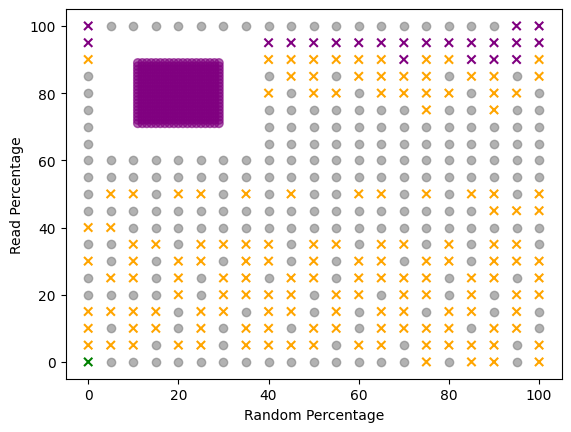

In [112]:
TYPE = 5 # Type for block size
color = ["red", "orange", "brown", "green", "blue", "purple"]

# known
x_known = []
y_known = []
color_known = []
# correctly reject
x_correctly_reject = []
y_correctly_reject = []
# mispredict
x_mispredict = []
y_mispredict = []
color_mp = []

for i in range(0, 101):
    for j in range(0, 101):
        ret = is_similar_iopattern(TYPE, i, j)
        if ret >= 0:
            x_known.append(j)
            y_known.append(i)
            color_known.append(color[ret])
        elif i % 5 != 0 or j % 5 != 0:
            continue
        elif is_unknown_iopattern(TYPE, i, j):
            mispredict_type = get_mispredict_type(mispred_logs, TYPE, i, j)
            if not mispredict_type:
                x_correctly_reject.append(j)
                y_correctly_reject.append(i)
            else:
                x_mispredict.append(j)
                y_mispredict.append(i)
                color_mp.append(color[mispredict_type])

plt.xlim(-5, 105)
plt.ylim(-5, 105)
plt.xlabel("Random Percentage")
plt.ylabel("Read Percentage")
plt.scatter(x_known, y_known, color=color_known, marker='o', alpha=0.6)
plt.scatter(x_correctly_reject, y_correctly_reject, color="grey", marker='o', alpha=0.6)
plt.scatter(x_mispredict, y_mispredict, color=color_mp, marker='x', alpha=1.0)